<a href="https://colab.research.google.com/github/srtaksande/MachineLearning/blob/main/CUDA_Lending_Club.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **1. Introduction**
LendingClub is a US peer-to-peer lending company, headquartered in San Francisco, California. It was the first peer-to-peer lender to register its offerings as securities with the Securities and Exchange Commission (SEC), and to offer loan trading on a secondary market. LendingClub is the world's largest peer-to-peer lending platform.

Solving this case study will give us an idea about how real business problems are solved using EDA and Machine Learning. In this case study, we will also develop a basic understanding of risk analytics in banking and financial services and understand how data is used to minimise the risk of losing money while lending to customers.

## **2. Mounting the Google Drive and setting up the work environment**

In [ ]:

import time
prog_start = time.time()

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!ls

gdrive	sample_data


## **3. Installing and loading the essential libraries**

In [ ]:
!pip3 install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.6/76.6 MB 12.3 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams
import time
from scipy import stats
import warnings
from sklearn import datasets
from sklearn import linear_model
from sklearn.metrics import explained_variance_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import RepeatedStratifiedKFold
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import plot_confusion_matrix, plot_roc_curve, roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.datasets import make_blobs
from sklearn import metrics
from math import sqrt
from numba import cuda

sns.set_style('darkgrid')
warnings.filterwarnings('ignore')

## **4. Reading the dataset**

In [ ]:
prog_start=time.time()

df = pd.read_csv ('/content/gdrive/My Drive/Colab Notebooks/accepted.csv', sep=',',low_memory=False)

df.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,68407277,NaN,3600.0,3600.0,3600.0,36 months,13.99,123.03,C,C4,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1,68355089,NaN,24700.0,24700.0,24700.0,36 months,11.99,820.28,C,C1,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
2,68341763,NaN,20000.0,20000.0,20000.0,60 months,10.78,432.66,B,B4,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
3,66310712,NaN,35000.0,35000.0,35000.0,60 months,14.85,829.90,C,C5,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
4,68476807,NaN,10400.0,10400.0,10400.0,60 months,22.45,289.91,F,F1,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
pd.options.display.max_columns = 200
df.describe()

,member_id,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,annual_inc,dti,delinq_2yrs,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_amnt,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,annual_inc_joint,dti_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_fico_range_low,sec_app_fico_range_high,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,deferral_term,hardship_amount,hardship_length,hardship_dpd,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,settlement_amount,settlement_percentage,settlement_term
count,0.0,2.260668e+06,2.260668e+06,2.260668e+06,2.260668e+06,2.260668e+06,2.260664e+06,2.258957e+06,2.260639e+06,2.260668e+06,2.260668e+06,2.260638e+06,1.102166e+06,359156.000000,2.260639e+06,2.260639e+06,2.260668e+06,2.258866e+06,2.260639e+06,2.260668e+06,2.260668e+06,2.260668e+06,2.260668e+06,2.260668e+06,2.260668e+06,2.260668e+06,2.260668e+06,2.260668e+06,2.260668e+06,2.260668e+06,2.260668e+06,2.260523e+06,580775.000000,2260668.0,1.207100e+05,120706.000000,2.260639e+06,2.190392e+06,2.190392e+06,1.394538e+06,1.394539e+06,1.394539e+06,1.394539e+06,1.350744e+06,1.394539e+06,1.191818e+06,1.394539e+06,1.394539e+06,1.394539e+06,1.394320e+06,2.190392e+06,1.394539e+06,1.394538e+06,1.394538e+06,2.210638e+06,2.190322e+06,2.185733e+06,2.184597e+06,2.260523e+06,2.260639e+06,2.121597e+06,2.190391e+06,2.190391e+06,2.190392e+06,2.210638e+06,2.187256e+06,519701.000000,1.965233e+06,740359.000000,2.190392e+06,2.190392e+06,2.190392e+06,2.202078e+06,2.190392e+06,2.190392e+06,2.190392e+06,2.190391e+06,2.190392e+06,2.202078e+06,2.107011e+06,2.190392e+06,2.190392e+06,2.190392e+06,2.190237e+06,2.185289e+06,2.259303e+06,2.260563e+06,2.190392e+06,2.210638e+06,2.210638e+06,2.190392e+06,1.080200e+05,108021.000000,108021.000000,108021.000000,108021.000000,108021.000000,106184.000000,108021.000000,108021.000000,108021.000000,108021.000000,35942.000000,10917.0,10917.000000,10917.0,10917.000000,8651.000000,10917.000000,10917.000000,34246.000000,34246.000000,34246.000000
mean,NaN,1.504693e+04,1.504166e+04,1.502344e+04,1.309283e+01,4.458068e+02,7.799243e+04,1.882420e+01,3.068792e-01,6.985882e+02,7.025884e+02,5.768354e-01,3.454092e+01,72.312842,1.161240e+01,1.975278e-01,1.665846e+04,5.033770e+01,2.416255e+01,4.206891e+03,4.205965e+03,1.208256e+04,1.206439e+04,9.505772e+03,2.431388e+03,1.518453e+00,1.438791e+02,2.398257e+01,3.429346e+03,6.876610e+02,6.755397e+02,1.814580e-02,44.164220,1.0,1.236246e+05,19.251817,4.147942e-03,2.327317e+02,1.424922e+05,9.344199e-01,2.779407e+00,6.764314e-01,1.562752e+00,2.122236e+01,3.550665e+04,6.914098e+01,1.290133e+00,2.749923e+00,5.806393e+03,5.703230e+01,3.457394e+04,1.012867e+00,1.47

In [ ]:
df.shape

(2260701, 151)

#### **4.1 Looking at Columns**

#### We will look at the columns in three installments. We will look at the first 60 columns first, then the next 60, and then the final 39 columns.

In [ ]:
def resumetable(df):
    print(f"Dataset Shape: {df.shape}")
    summary = pd.DataFrame(df.dtypes,columns=['dtypes'])
    summary = summary.reset_index()
    summary['Name'] = summary['index']
    summary = summary[['Name','dtypes']]
    summary['Missing'] = df.isnull().sum().values
    summary['Uniques'] = df.nunique().values
    summary['First Value'] = df.loc[0].values
    summary['Second Value'] = df.loc[1].values
    summary['Third Value'] = df.loc[2].values

    for name in summary['Name'].value_counts().index:
        summary.loc[summary['Name'] == name, 'Entropy'] = round(stats.entropy(df[name].value_counts(normalize=True), base=2),2)

    return summary

#### The columns are mentioned along with the datatype, missing values, unique values, first, second and third values and finally the entropy of the column. The entropy is defined as the measure of disorder or uncertainity. If the entropy is 0.88, this is considered a high entropy , a high level of disorder ( meaning low level of purity).



In [ ]:
resumetable(df[:100000])[:60]

Dataset Shape: (100000, 151)


,Name,dtypes,Missing,Uniques,First Value,Second Value,Third Value,Entropy
0,id,object,0,100000,68407277,68355089,68341763,16.61
1,member_id,float64,100000,0,NaN,NaN,NaN,0.00
2,loan_amnt,float64,0,1350,3600.0,24700.0,20000.0,6.79
3,funded_amnt,float64,0,1350,3600.0,24700.0,20000.0,6.79
4,funded_amnt_inv,float64,0,1354,3600.0,24700.0,20000.0,7.12
5,term,object,0,2,36 months,36 months,60 months,0.90
6,int_rate,float64,0,81,13.99,11.99,10.78,5.47
7,installment,float64,0,18075,123.03,820.28,432.66,12.03
8,grade,object,0,7,C,C,B,2.27
9,sub_grade,object,0,35,C4,C1,B4,4.57


In [ ]:
resumetable(df[:100000])[60:112]

Dataset Shape: (100000, 151)


,Name,dtypes,Missing,Uniques,First Value,Second Value,Third Value,Entropy
60,acc_now_delinq,float64,0,5,0.0,0.0,0.0,0.05
61,tot_coll_amt,float64,0,4010,722.0,0.0,0.0,2.40
62,tot_cur_bal,float64,0,82713,144904.0,204396.0,189699.0,16.24
63,open_acc_6m,float64,78628,13,2.0,1.0,0.0,2.06
64,open_act_il,float64,78628,35,2.0,1.0,1.0,3.05
65,open_il_12m,float64,78628,12,0.0,0.0,0.0,1.71
66,open_il_24m,float64,78628,17,1.0,1.0,4.0,2.47
67,mths_since_rcnt_il,float64,79190,201,21.0,19.0,19.0,5.67
68,total_bal_il,float64,78628,17030,4981.0,18005.0,10827.0,13.00
69,il_util,float64,81383,160,36.0,73.0,73.0,6.45


In [ ]:
resumetable(df[:100000])[112:]

Dataset Shape: (100000, 151)


,Name,dtypes,Missing,Uniques,First Value,Second Value,Third Value,Entropy
112,total_bal_ex_mort,float64,0,65554,7746.0,39475.0,18696.0,15.82
113,total_bc_limit,float64,0,2759,2400.0,79300.0,6200.0,9.27
114,total_il_high_credit_limit,float64,0,55965,13734.0,24667.0,14877.0,14.05
115,revol_bal_joint,float64,100000,0,NaN,NaN,NaN,0.00
116,sec_app_fico_range_low,float64,100000,0,NaN,NaN,NaN,0.00
117,sec_app_fico_range_high,float64,100000,0,NaN,NaN,NaN,0.00
118,sec_app_earliest_cr_line,object,100000,0,NaN,NaN,NaN,0.00
119,sec_app_inq_last_6mths,float64,100000,0,NaN,NaN,NaN,0.00
120,sec_app_mort_acc,float64,100000,0,NaN,NaN,NaN,0.00
121,sec_app_open_acc,float64,100000,0,NaN,NaN,NaN,0.00


#### Accroding to the missing values, unique values and the entropy, we have removed the following columns. These columns are excluded from the analysis.

In [ ]:
df.drop(columns=['member_id','desc','mths_since_last_delinq','mths_since_last_record','mths_since_last_major_derog','annual_inc_joint','dti_joint','total_bal_il',
'total_bal_il','max_bal_bc','bc_open_to_buy','revol_bal_joint','sec_app_fico_range_low','sec_app_fico_range_high','sec_app_earliest_cr_line','sec_app_inq_last_6mths','sec_app_mort_acc',
'sec_app_open_acc','sec_app_revol_util','sec_app_open_act_il','sec_app_num_rev_accts','sec_app_chargeoff_within_12_mths','sec_app_collections_12_mths_ex_med','sec_app_mths_since_last_major_derog',
'hardship_type','deferral_term','hardship_length'], inplace=True)

In [ ]:
df.drop(columns=['id'], inplace=True)

#### The shape of the dataset after removing the columns is:

In [ ]:
df.shape

(2260701, 124)

In [ ]:
df.dtypes

loan_amnt                float64
funded_amnt              float64
funded_amnt_inv          float64
term                      object
int_rate                 float64
                          ...   
settlement_status         object
settlement_date           object
settlement_amount        float64
settlement_percentage    float64
settlement_term          float64
Length: 124, dtype: object

## **5. Exploratory Data Analysis (Data Visualization) of Lending Club Dataset**

#### For our EDA, we first want to see the different loan categories in the dataset.

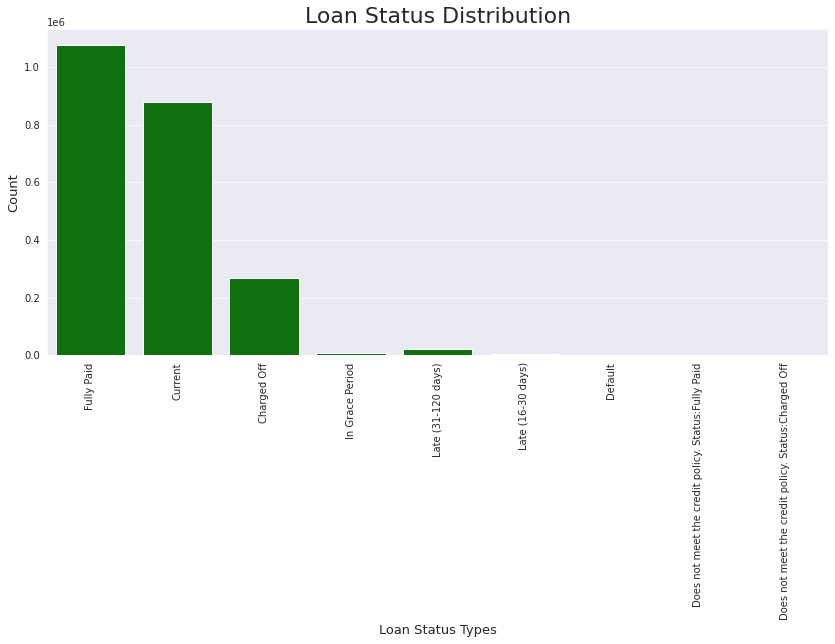

In [ ]:
plt.figure(figsize = (14,6))
g = sns.countplot(x="loan_status", data=df, color='green')
g.set_xticklabels(g.get_xticklabels(),rotation=90)
g.set_xlabel("Loan Status Types", fontsize=13)
g.set_ylabel("Count", fontsize=13)
g.set_title("Loan Status Distribution", fontsize=22)
plt.show()

#### Next, it would be interesting to understand the reason for borrowing the loan. For this we have taken the column **'purpose'**.

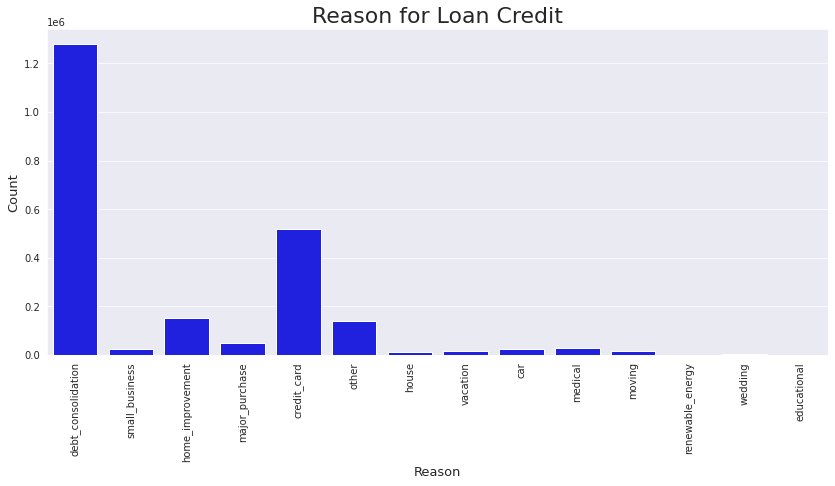

In [ ]:
plt.figure(figsize=(14,6))
g = sns.countplot(x='purpose', data=df, color='blue')
g.set_xticklabels(g.get_xticklabels(),rotation=90)
g.set_title("Reason for Loan Credit", fontsize=22)
g.set_xlabel("Reason", fontsize=13)
g.set_ylabel('Count', fontsize=13)
plt.show()

#### Debt consolidation and credit card are the main reasons for borrowing a loan.

#### **Loan Status Distribution**

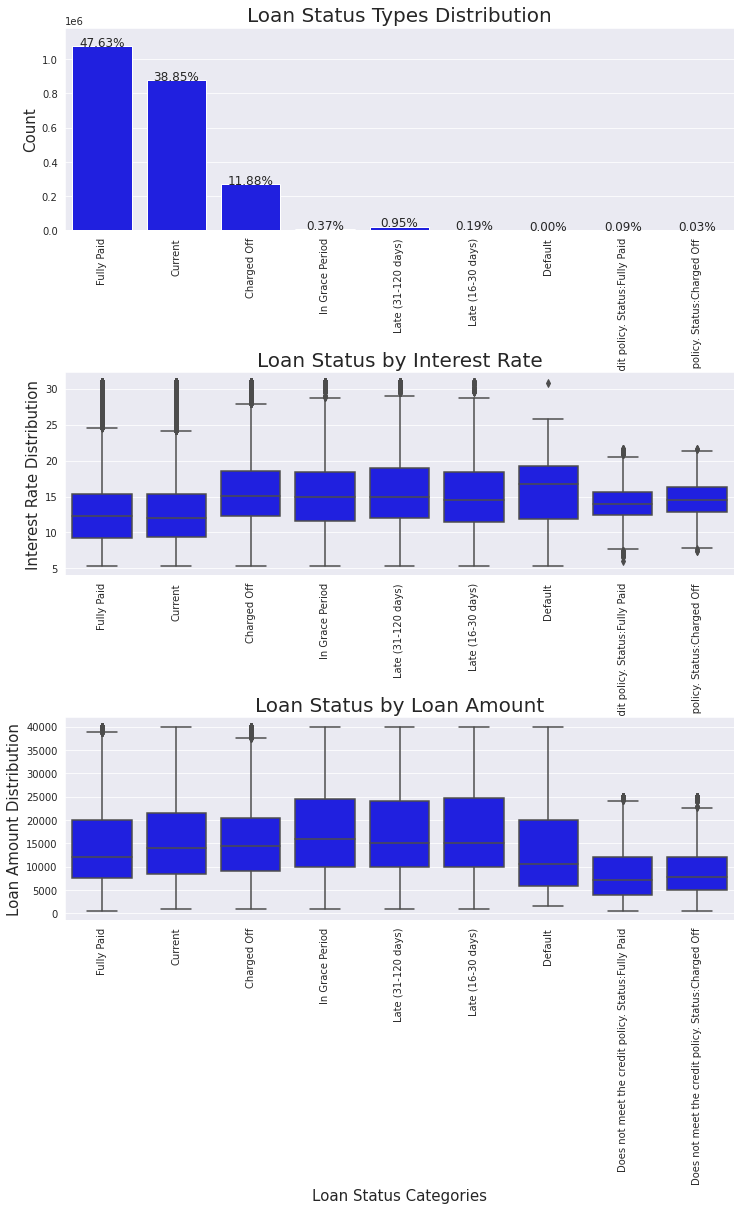

In [ ]:
plt.figure(figsize = (12,16))
total = len(df)
plt.subplot(311)
g = sns.countplot(x="loan_status", data=df,
                  color='blue')
g.set_xticklabels(g.get_xticklabels(),rotation=90)
g.set_xlabel("Loan Status Categories", fontsize=12)
g.set_ylabel("Count", fontsize=15)
g.set_title("Loan Status Types Distribution", fontsize=20)
sizes=[]
for p in g.patches:
    height = p.get_height()
    sizes.append(height)
    g.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/total*100),
            ha="center", fontsize=12)
g.set_ylim(0, max(sizes) * 1.10)

plt.subplot(312)
g1 = sns.boxplot(x="loan_status", y="int_rate", data=df, color='blue')
g1.set_xticklabels(g1.get_xticklabels(),rotation=90)
g1.set_xlabel("Loan Status Categories", fontsize=12)
g1.set_ylabel("Interest Rate Distribution", fontsize=15)
g1.set_title("Loan Status by Interest Rate", fontsize=20)
plt.subplot(313)
g2 = sns.boxplot(x="loan_status", y="loan_amnt", data=df,
                 color='blue')
g2.set_xticklabels(g2.get_xticklabels(),rotation=90)
g2.set_xlabel("Loan Status Categories", fontsize=15)
g2.set_ylabel("Loan Amount Distribution", fontsize=15)
g2.set_title("Loan Status by Loan Amount", fontsize=20)

plt.subplots_adjust(hspace = 0.7,top = 0.9)

plt.show()

## **5.1 Crosstabs**

#### **Purpose by Loan Status**

In [ ]:
purp_loan= ['purpose', 'loan_status']
cm = sns.light_palette("green", as_cmap=True)
(round(pd.crosstab(df[purp_loan[0]], df[purp_loan[1]],
                   normalize='columns') * 100,2)).style.background_gradient(cmap = cm)

loan_status,Charged Off,Current,Default,Does not meet the credit policy. Status:Charged Off,Does not meet the credit policy. Status:Fully Paid,Fully Paid,In Grace Period,Late (16-30 days),Late (31-120 days)
purpose,,,,,,,,,
car,0.800000,1.030000,7.500000,1.710000,2.570000,1.160000,0.890000,0.690000,0.890000
credit_card,18.610000,24.460000,15.000000,9.070000,13.630000,22.780000,19.820000,18.850000,18.700000
debt_consolidation,61.440000,54.240000,52.500000,38.370000,40.640000,57.140000,59.250000,57.990000,58.110000
educational,0.020000,0.000000,0.000000,4.200000,3.270000,0.030000,0.000000,0.000000,0.000000
home_improvement,5.770000,6.880000,7.500000,9.330000,7.190000,6.690000,6.610000,7.470000,6.710000
house,0.590000,0.750000,2.500000,1.450000,1.660000,0.530000,0.720000,0.970000,0.870000
major_purchase,2.040000,2.280000,5.000000,3.020000,5.030000,2.220000,2.230000,2.460000,2.650000
medical,1.260000,1.300000,5.000000,2.890000,1.810000,1.130000,1.260000,1.130000,1.370000
moving,0.820000,0.640000,0.000000,1.970000,1.560000,0.670000,0.700000,0.990000,0.830000


#### **Grade by Loan Status**

In [ ]:
purp_loan= ['purpose', 'loan_status']
cm = sns.light_palette("green", as_cmap=True)
(round(pd.crosstab(df[purp_loan[0]], df[purp_loan[1]],
                   normalize='columns') * 100,2)).style.background_gradient(cmap = cm)

loan_status,Charged Off,Current,Default,Does not meet the credit policy. Status:Charged Off,Does not meet the credit policy. Status:Fully Paid,Fully Paid,In Grace Period,Late (16-30 days),Late (31-120 days)
purpose,,,,,,,,,
car,0.800000,1.030000,7.500000,1.710000,2.570000,1.160000,0.890000,0.690000,0.890000
credit_card,18.610000,24.460000,15.000000,9.070000,13.630000,22.780000,19.820000,18.850000,18.700000
debt_consolidation,61.440000,54.240000,52.500000,38.370000,40.640000,57.140000,59.250000,57.990000,58.110000
educational,0.020000,0.000000,0.000000,4.200000,3.270000,0.030000,0.000000,0.000000,0.000000
home_improvement,5.770000,6.880000,7.500000,9.330000,7.190000,6.690000,6.610000,7.470000,6.710000
house,0.590000,0.750000,2.500000,1.450000,1.660000,0.530000,0.720000,0.970000,0.870000
major_purchase,2.040000,2.280000,5.000000,3.020000,5.030000,2.220000,2.230000,2.460000,2.650000
medical,1.260000,1.300000,5.000000,2.890000,1.810000,1.130000,1.260000,1.130000,1.370000
moving,0.820000,0.640000,0.000000,1.970000,1.560000,0.670000,0.700000,0.990000,0.830000


#### **Interest Rate by Grade and Loan Status**

In [ ]:
loan_grade = ['loan_status', 'grade']
cm = sns.light_palette("green", as_cmap=True)
round(pd.crosstab(df[loan_grade[0]], df[loan_grade[1]],
            values=df['int_rate'], aggfunc='mean'),2).fillna(0).style.background_gradient(cmap = cm)

grade,A,B,C,D,E,F,G
loan_status,,,,,,,
Charged Off,7.390000,10.790000,14.080000,17.790000,21.200000,25.100000,27.950000
Current,7.050000,10.670000,14.320000,18.850000,23.460000,27.380000,29.790000
Default,7.200000,11.040000,13.870000,18.860000,24.520000,30.740000,0.000000
Does not meet the credit policy. Status:Charged Off,8.300000,10.760000,12.610000,14.480000,15.530000,17.180000,18.860000
Does not meet the credit policy. Status:Fully Paid,8.090000,10.760000,12.870000,14.440000,15.570000,17.190000,18.930000
Fully Paid,7.100000,10.660000,14.000000,17.690000,21.100000,24.800000,27.510000
In Grace Period,7.270000,10.700000,14.350000,18.750000,23.390000,27.500000,29.620000
Late (16-30 days),7.190000,10.790000,14.380000,18.910000,23.740000,27.850000,30.140000
Late (31-120 days),7.250000,10.730000,14.360000,18.910000,23.670000,27.920000,30.130000


#### **Verification Status**
This indicates if the income was verified by LC, not verified, or if the income source was verified.

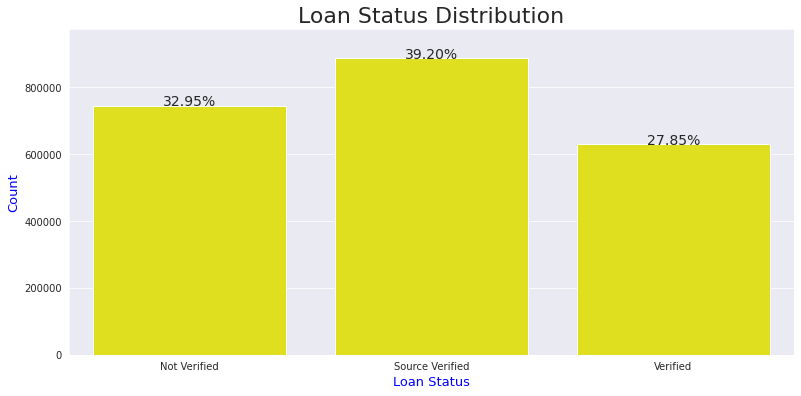

In [ ]:
plt.figure(figsize = (13,6))
g = sns.countplot(x="verification_status", data=df, color='yellow')
g.set_xlabel("Loan Status", fontsize=13, color='blue')
g.set_ylabel("Count", fontsize=13, color='blue')
g.set_title("Loan Status Distribution", fontsize=22)
sizes=[]
for p in g.patches:
    height = p.get_height()
    sizes.append(height)
    g.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/total*100),
            ha="center", fontsize=14)
g.set_ylim(0, max(sizes) * 1.10)
plt.show()

#### Source verified status has the highest distribution.

#### **Loan Status by Verification Status**

In [ ]:
loan_verification = ['loan_status', 'verification_status']
cm = sns.light_palette("green", as_cmap=True)
pd.crosstab(df[loan_verification[0]], df[loan_verification[1]],
            normalize='index').style.background_gradient(cmap = cm)

verification_status,Not Verified,Source Verified,Verified
loan_status,,,
Charged Off,0.221683,0.406734,0.371583
Current,0.373559,0.398717,0.227724
Default,0.200000,0.400000,0.400000
Does not meet the credit policy. Status:Charged Off,0.671485,0.107753,0.220762
Does not meet the credit policy. Status:Fully Paid,0.664487,0.104628,0.230885
Fully Paid,0.321491,0.382671,0.295838
In Grace Period,0.266240,0.423661,0.310100
Late (16-30 days),0.275236,0.420556,0.304208
Late (31-120 days),0.266409,0.421531,0.312060


#### **Installment**
It is the monthly payment owed by the borrower if the loan originates.

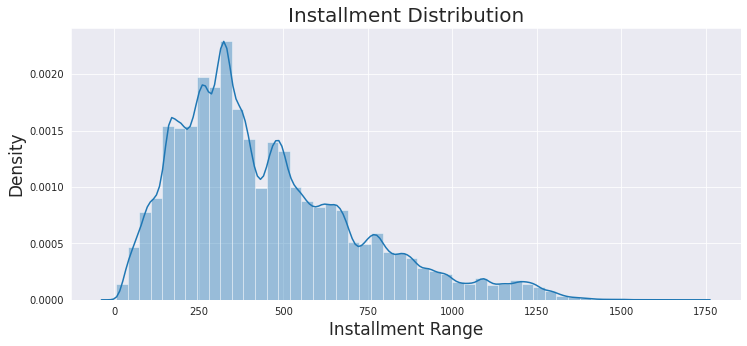

In [ ]:
plt.figure(figsize=(12,5))
sns.distplot(df['installment'])
plt.title("Installment Distribution", fontsize=20)
plt.xlabel("Installment Range", fontsize=17)
plt.ylabel("Density", fontsize=17)
plt.show()

#### We can see the peak of the installments are at monthly ~300USD.

#### **Loan Status by Application Type**

In [ ]:
loan_application = ['loan_status', 'application_type']
cm = sns.light_palette("green", as_cmap=True)
pd.crosstab(df[loan_application[0]], df[loan_application[1]]).style.background_gradient(cmap = cm)

application_type,Individual,Joint App
loan_status,,
Charged Off,262215,6344
Current,787191,91126
Default,34,6
Does not meet the credit policy. Status:Charged Off,761,0
Does not meet the credit policy. Status:Fully Paid,1988,0
Fully Paid,1057295,19456
In Grace Period,7342,1094
Late (16-30 days),3843,506
Late (31-120 days),19289,2178


#### **Loan Status by Home Ownership**

In [ ]:
loan_home = ['loan_status', 'home_ownership']
cm = sns.light_palette("green", as_cmap=True)
round(pd.crosstab(df[loan_home[0]], df[loan_home[1]],
            normalize='index'),2).fillna(0).style.background_gradient(cmap = cm)

home_ownership,ANY,MORTGAGE,NONE,OTHER,OWN,RENT
loan_status,,,,,,
Charged Off,0.000000,0.430000,0.000000,0.000000,0.110000,0.460000
Current,0.000000,0.490000,0.000000,0.000000,0.120000,0.390000
Default,0.000000,0.420000,0.000000,0.000000,0.200000,0.380000
Does not meet the credit policy. Status:Charged Off,0.000000,0.460000,0.000000,0.010000,0.060000,0.460000
Does not meet the credit policy. Status:Fully Paid,0.000000,0.460000,0.000000,0.010000,0.070000,0.460000
Fully Paid,0.000000,0.510000,0.000000,0.000000,0.110000,0.380000
In Grace Period,0.000000,0.480000,0.000000,0.000000,0.110000,0.410000
Late (16-30 days),0.000000,0.440000,0.000000,0.000000,0.130000,0.430000
Late (31-120 days),0.000000,0.430000,0.000000,0.000000,0.130000,0.440000


#### **Mean Interest Rate by Grade and Sub-Grade**

In [ ]:
loan_grade = ['sub_grade', 'grade']
cm = sns.light_palette("green", as_cmap=True)
round(pd.crosstab(df[loan_grade[0]], df[loan_grade[1]],
            values=df['int_rate'], aggfunc='mean'),2).fillna(0).style.background_gradient(cmap = cm)

grade,A,B,C,D,E,F,G
sub_grade,,,,,,,
A1,5.600000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
A2,6.550000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
A3,7.090000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
A4,7.560000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
A5,8.200000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
B1,0.000000,9.080000,0.000000,0.000000,0.000000,0.000000,0.000000
B2,0.000000,9.970000,0.000000,0.000000,0.000000,0.000000,0.000000
B3,0.000000,10.710000,0.000000,0.000000,0.000000,0.000000,0.000000
B4,0.000000,11.370000,0.000000,0.000000,0.000000,0.000000,0.000000


#### **Employee Title**
Lets look at the employee titles and respective grades and sub-grades allocated to them.

#### **Grades for each employee title**

In [ ]:
title_mask = df.emp_title.value_counts()[:20].index.values
cm = sns.light_palette("green", as_cmap=True)
round(pd.crosstab(df[df['emp_title'].isin(title_mask)]['emp_title'],
                  df[df['emp_title'].isin(title_mask)]['sub_grade'],
                  normalize='index') * 100,2).style.background_gradient(cmap = cm)

sub_grade,A1,A2,A3,A4,A5,B1,B2,B3,B4,B5,C1,C2,C3,C4,C5,D1,D2,D3,D4,D5,E1,E2,E3,E4,E5,F1,F2,F3,F4,F5,G1,G2,G3,G4,G5
emp_title,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Accountant,3.430000,3.410000,3.450000,4.810000,5.220000,6.340000,6.180000,5.880000,6.180000,6.490000,6.590000,5.650000,5.560000,5.400000,4.840000,3.130000,2.970000,2.970000,2.110000,1.980000,1.410000,1.160000,0.980000,0.790000,1.000000,0.480000,0.290000,0.270000,0.230000,0.210000,0.300000,0.110000,0.070000,0.040000,0.070000
Director,6.830000,3.970000,3.970000,5.200000,5.360000,6.150000,5.740000,6.010000,6.350000,5.930000,6.600000,5.080000,5.340000,5.450000,4.240000,2.930000,2.460000,2.190000,2.210000,1.580000,1.100000,0.770000,0.990000,0.990000,0.810000,0.360000,0.310000,0.200000,0.360000,0.190000,0.110000,0.070000,0.080000,0.070000,0.000000
Driver,2.450000,2.280000,2.960000,3.750000,3.940000,5.420000,5.420000,5.440000,6.190000,6.670000,6.740000,6.320000,5.880000,5.960000,5.840000,4.010000,4.020000,3.180000,2.890000,2.390000,1.380000,1.170000,1.210000,1.100000,1.040000,0.490000,0.390000,0.400000,0.290000,0.160000,0.210000,0.150000,0.090000,0.080000,0.090000
Engineer,6.430000,4.440000,4.490000,5.260000,5.630000,5.980000,5.890000,6.120000,5.890000,5.500000,6.020000,5.600000,4.810000,4.830000,4.650000,2.880000,2.520000,2.620000,2.070000,1.490000,1.440000,0.960000,0.880000,0.710000,0.860000,0.630000,0.370000,0.330000,0.160000,0.100000,0.160000,0.080000,0.050000,0.080000,0.070000
General Manager,4.180000,3.190000,2.940000,3.970000,5.250000,5.880000,5.960000,5.730000,5.820000,6.380000,6.540000,6.120000,5.620000,5.560000,5.340000,3.420000,3.030000,2.790000,2.370000,1.980000,1.390000,1.260000,1.140000,0.940000,1.040000,0.440000,0.480000,0.300000,0.270000,0.190000,0.190000,0.090000,0.120000,0.090000,0.010000
Manager,3.850000,3.020000,3.290000,4.200000,4.950000,5.530000,5.490000,5.530000,5.990000,6.250000,6.480000,5.860000,5.990000,5.720000,5.390000,3.380000,3.200000,2.800000,2.490000,2.150000,1.500000,1.360000,1.200000,0.920000,1.010000,0.580000,0.380000,0.370000,0.280000,0.210000,0.190000,0.170000,0.090000,0.100000,0.090000
Office Manager,3.190000,3.150000,3.260000,4.270000,4.870000,5.430000,5.430000,5.270000,6.000000,6.640000,6.440000,5.580000,6.170000,5.710000,5.560000,3.760000,3.100000,3.170000,2.280000,2.350000,1.550000,1.410000,1.260000,0.750000,1.240000,0.590000,0.330000,0.260000,0.270000,0.290000,0.140000,0.100000,0.060000,0.060000,0.060000
Operations Manager,3.850000,3.080000,3.380000,4.110000,5.120000,5.890000,5.790000,5.320000,5.760000,6.020000,6.580000,6.200000,5.830000,5.740000,4.990000,3.460000,3.210000,2.330000,2.630000,2.250000,1.570000,1.240000,1.320000,0.860000,1.170000,0.600000,0.260000,0.340000,0.330000,0.180000,0.240000,0.080000,0.080000,0.100000,0.050000
Owner,4.560000,3.840000,3.580000,4.460000,4.810000,6.770000,6.240000,5.970000,6.140000,6.040000,6.550000,5.950000,5.200000,5.280000,4.810000,3.560000,3.020000,2.530000,2.080000,1.880000,1.180000,1.130000,0.990000,0.780000,0.770000,0.370000,0.290000,0.280000,0.250000,0.220000,0.190000,0.100000,0.070000,0.060000,0.080000


#### We can see that Director, Engineer, Vice President are the categories with highest incidence in Grade A. Analyzing this table we can get some insights about the profile of grades and professionals.

#### **Interest rates according to employee lengths**

In [ ]:
df.groupby(["emp_length"])['int_rate'].mean().reset_index().T

,0,1,2,3,4,5,6,7,8,9,10
emp_length,1 year,10+ years,2 years,3 years,4 years,5 years,6 years,7 years,8 years,9 years,< 1 year
int_rate,13.189791,13.002788,13.127222,13.120526,13.13112,13.141375,13.176806,13.19482,13.097373,13.07509,13.073689


#### The interest rate for employee lengths of 2 years is the highest and the lowest interest rate is for 9 years.

#### **DTI**
DTI is a ratio calculated using the borrower’s total monthly debt payments on the total debt obligations, excluding mortgage and the requested LC loan, divided by the borrower’s self-reported monthly income.

In [ ]:
cm = sns.light_palette("green", as_cmap=True)
round((pd.crosstab(df['loan_status'], df['purpose'],
            values=df['dti'], aggfunc='mean')).fillna(0),
      2).style.background_gradient(cmap = cm)

purpose,car,credit_card,debt_consolidation,educational,home_improvement,house,major_purchase,medical,moving,other,renewable_energy,small_business,vacation,wedding
loan_status,,,,,,,,,,,,,,
Charged Off,17.470000,20.510000,20.820000,11.050000,17.790000,16.770000,16.400000,19.570000,18.440000,18.630000,17.130000,15.710000,19.100000,15.170000
Current,16.430000,19.760000,20.280000,17.070000,18.270000,15.460000,16.460000,19.390000,18.500000,17.850000,17.940000,15.820000,19.400000,13.840000
Default,13.930000,11.090000,21.580000,0.000000,7.500000,8.800000,12.250000,22.740000,0.000000,13.820000,0.000000,0.000000,0.000000,0.000000
Does not meet the credit policy. Status:Charged Off,11.540000,15.140000,15.500000,13.660000,13.350000,8.610000,12.460000,14.960000,8.030000,14.120000,15.770000,13.620000,15.780000,13.650000
Does not meet the credit policy. Status:Fully Paid,9.920000,15.700000,15.700000,10.190000,13.370000,10.240000,11.540000,15.160000,12.440000,12.680000,7.340000,11.680000,10.600000,13.040000
Fully Paid,14.500000,18.060000,18.450000,11.270000,15.650000,14.080000,14.480000,17.080000,16.000000,16.550000,15.890000,14.110000,17.310000,13.830000
In Grace Period,15.070000,21.100000,21.470000,0.000000,17.570000,15.140000,15.000000,18.250000,18.630000,18.130000,25.880000,16.280000,16.910000,0.000000
Late (16-30 days),18.010000,19.840000,20.110000,0.000000,18.550000,15.560000,15.800000,17.730000,18.370000,17.860000,7.240000,17.010000,24.200000,0.000000
Late (31-120 days),16.650000,20.730000,20.890000,0.000000,18.190000,14.220000,16.240000,19.500000,22.390000,18.050000,17.850000,15.770000,20.000000,0.000000


## **6. Dealing with the missing values**

In [ ]:
df.isnull().sum()

loan_amnt                     33
funded_amnt                   33
funded_amnt_inv               33
term                          33
int_rate                      33
                          ...   
settlement_status        2226455
settlement_date          2226455
settlement_amount        2226455
settlement_percentage    2226455
settlement_term          2226455
Length: 124, dtype: int64

In [ ]:
df.isnull().mean()

loan_amnt                0.000015
funded_amnt              0.000015
funded_amnt_inv          0.000015
term                     0.000015
int_rate                 0.000015
                           ...   
settlement_status        0.984852
settlement_date          0.984852
settlement_amount        0.984852
settlement_percentage    0.984852
settlement_term          0.984852
Length: 124, dtype: float64

In [ ]:
df.head()

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,policy_code,application_type,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,il_util,open_rv_12m,open_rv_24m,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,hardship_flag,hardship_reason,hardship_status,hardship_amount,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,3600.0,3600.0,3600.0,36 months,13.99,123.03,C,C4,leadman,10+ years,MORTGAGE,55000.0,Not Verified,Dec-2015,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,debt_consolidation,Debt consolidation,190xx,PA,5.91,0.0,Aug-2003,675.0,679.0,1.0,7.0,0.0,2765.0,29.7,13.0,w,0.00,0.00,4421.723917,4421.72,3600.00,821.72,0.0,0.0,0.0,Jan-2019,122.67,NaN,Mar-2019,564.0,560.0,0.0,1.0,Individual,NaN,0.0,722.0,144904.0,2.0,2.0,0.0,1.0,21.0,36.0,3.0,3.0,34.0,9300.0,3.0,1.0,4.0,4.0,20701.0,37.2,0.0,0.0,148.0,128.0,3.0,3.0,1.0,4.0,69.0,4.0,69.0,2.0,2.0,4.0,2.0,5.0,3.0,4.0,9.0,4.0,7.0,0.0,0.0,0.0,3.0,76.9,0.0,0.0,0.0,178050.0,7746.0,2400.0,13734.0,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1,24700.0,24700.0,24700.0,36 months,11.99,820.28,C,C1,Engineer,10+ years,MORTGAGE,65000.0,Not Verified,Dec-2015,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,small_business,Business,577xx,SD,16.06,1.0,Dec-1999,715.0,719.0,4.0,22.0,0.0,21470.0,19.2,38.0,w,0.00,0.00,25679.660000,25679.66,24700.00,979.66,0.0,0.0,0.0,Jun-2016,926.35,NaN,Mar-2019,699.0,695.0,0.0,1.0,Individual,NaN,0.0,0.0,204396.0,1.0,1.0,0.0,1.0,19.0,73.0,2.0,3.0,29.0,111800.0,0.0,0.0,6.0,4.0,9733.0,27.1,0.0,0.0,113.0,192.0,2.0,2.0,4.0,2.0,NaN,0.0,6.0,0.0,5.0,5.0,13.0,17.0,6.0,20.0,27.0,5.0,22.0,0.0,0.0,0.0,2.0,97.4,7.7,0.0,0.0,314017.0,39475.0,79300.0,24667.0,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
2,20000.0,20000.0,20000.0,60 months,10.78,432.66,B,B4,truck driver,10+ years,MORTGAGE,63000.0,Not Verified,Dec-2015,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,home_improvement,NaN,605xx,IL,10.78,0.0,Aug-2000,695.0,699.0,0.0,6.0,0.0,7869.0,56.2,18.0,w,0.00,0.00,22705.924294,22705.92,20000.00,2705.92,0.0,0.0,0.0,Jun-2017,15813.30,NaN,Mar-2019,704.0,700.0,0.0,1.0,Joint App,Not Verified,0.0,0.0,189699.0,0.0,1.0,0.0,4.0,19.0,73.0,0.0,2.0,65.0,14000.0,2.0,5.0,1.0,6.0,31617.0,55.9,0.0,0.0,125.0,184.0,14.0,14.0,5.0,101.0,NaN,10.0,NaN,0.0,2.0,3.0,2.0,4.0,6.0,4.0,7.0,3.0,6.0,0.0,0.0,0.0,0.0,100.0,50.0,0.0,0.0,218418.0,186

#### Dropping columns containing either 40% or more than 40% NaN values.

In [ ]:
perc = 40.0
min_count =  int(((100-perc)/100)*df.shape[0] + 1)
mod_df = df.dropna( axis=1,
                thresh=min_count)
print("Modified Dataframe : ")
print(mod_df)

Modified Dataframe : 
         loan_amnt  funded_amnt  funded_amnt_inv        term  int_rate  \
0           3600.0       3600.0           3600.0   36 months     13.99   
1          24700.0      24700.0          24700.0   36 months     11.99   
2          20000.0      20000.0          20000.0   60 months     10.78   
3          35000.0      35000.0          35000.0   60 months     14.85   
4          10400.0      10400.0          10400.0   60 months     22.45   
...            ...          ...              ...         ...       ...   
2260696    40000.0      40000.0          40000.0   60 months     10.49   
2260697    24000.0      24000.0          24000.0   60 months     14.49   
2260698    14000.0      14000.0          14000.0   60 months     14.49   
2260699        NaN          NaN              NaN         NaN       NaN   
2260700        NaN          NaN              NaN         NaN       NaN   

         installment grade sub_grade                    emp_title emp_length  \
0        

In [ ]:
mod_df.isnull().mean()

loan_amnt                     0.000015
funded_amnt                   0.000015
funded_amnt_inv               0.000015
term                          0.000015
int_rate                      0.000015
                                ...   
total_bc_limit                0.022145
total_il_high_credit_limit    0.031101
hardship_flag                 0.000015
disbursement_method           0.000015
debt_settlement_flag          0.000015
Length: 101, dtype: float64

In [ ]:
mod_df.head()

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,last_credit_pull_d,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,policy_code,application_type,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,open_rv_12m,open_rv_24m,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_inq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,hardship_flag,disbursement_method,debt_settlement_flag
0,3600.0,3600.0,3600.0,36 months,13.99,123.03,C,C4,leadman,10+ years,MORTGAGE,55000.0,Not Verified,Dec-2015,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,debt_consolidation,Debt consolidation,190xx,PA,5.91,0.0,Aug-2003,675.0,679.0,1.0,7.0,0.0,2765.0,29.7,13.0,w,0.00,0.00,4421.723917,4421.72,3600.00,821.72,0.0,0.0,0.0,Jan-2019,122.67,Mar-2019,564.0,560.0,0.0,1.0,Individual,0.0,722.0,144904.0,2.0,2.0,0.0,1.0,3.0,3.0,34.0,9300.0,3.0,1.0,4.0,4.0,20701.0,37.2,0.0,0.0,148.0,128.0,3.0,3.0,1.0,4.0,4.0,2.0,2.0,4.0,2.0,5.0,3.0,4.0,9.0,4.0,7.0,0.0,0.0,0.0,3.0,76.9,0.0,0.0,0.0,178050.0,7746.0,2400.0,13734.0,N,Cash,N
1,24700.0,24700.0,24700.0,36 months,11.99,820.28,C,C1,Engineer,10+ years,MORTGAGE,65000.0,Not Verified,Dec-2015,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,small_business,Business,577xx,SD,16.06,1.0,Dec-1999,715.0,719.0,4.0,22.0,0.0,21470.0,19.2,38.0,w,0.00,0.00,25679.660000,25679.66,24700.00,979.66,0.0,0.0,0.0,Jun-2016,926.35,Mar-2019,699.0,695.0,0.0,1.0,Individual,0.0,0.0,204396.0,1.0,1.0,0.0,1.0,2.0,3.0,29.0,111800.0,0.0,0.0,6.0,4.0,9733.0,27.1,0.0,0.0,113.0,192.0,2.0,2.0,4.0,2.0,0.0,0.0,5.0,5.0,13.0,17.0,6.0,20.0,27.0,5.0,22.0,0.0,0.0,0.0,2.0,97.4,7.7,0.0,0.0,314017.0,39475.0,79300.0,24667.0,N,Cash,N
2,20000.0,20000.0,20000.0,60 months,10.78,432.66,B,B4,truck driver,10+ years,MORTGAGE,63000.0,Not Verified,Dec-2015,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,home_improvement,NaN,605xx,IL,10.78,0.0,Aug-2000,695.0,699.0,0.0,6.0,0.0,7869.0,56.2,18.0,w,0.00,0.00,22705.924294,22705.92,20000.00,2705.92,0.0,0.0,0.0,Jun-2017,15813.30,Mar-2019,704.0,700.0,0.0,1.0,Joint App,0.0,0.0,189699.0,0.0,1.0,0.0,4.0,0.0,2.0,65.0,14000.0,2.0,5.0,1.0,6.0,31617.0,55.9,0.0,0.0,125.0,184.0,14.0,14.0,5.0,101.0,10.0,0.0,2.0,3.0,2.0,4.0,6.0,4.0,7.0,3.0,6.0,0.0,0.0,0.0,0.0,100.0,50.0,0.0,0.0,218418.0,18696.0,6200.0,14877.0,N,Cash,N
3,35000.0,35000.0,35000.0,60 months,14.85,829.90,C,C5,Information Systems Officer,10+ years,MORTGAGE,110000.0,Source Verified,Dec-2015,Current,n,https://lendingclub.com/browse/loanDetail.acti...,debt_consolidation,Debt consolidation,076xx,NJ,17.06,0.0,Sep-2008,785.0,789.0,0.0,13.0,0.0,7802.0,11.6,17.0,w,15897.65,15897.65,31464.010000,31464.01,19102.35,12361.66,0.0,0.0,0.0,Feb-2019,829.90,Mar-2019,679.0,675.0,0.0,1.0,Individual,0.0,0.0,301500.0,1.0,1.0,0.0,1.0,1.0,1.0,45.0,67300.0,0.0,1.0,0.0,2.0,23192.0,12.1,0.0,0.0,36.0,87.0,2.0,2.0,1.0,2.0,NaN,0.0,4.0,5.0,8.0,10.0,2.0,10.0,13.0,5.0,13.0,0.0,0.0,0.0,1.0,100.0,0.0,0.0,0.0,381215.0,52226.0,62500.0,18000.0,N,Cash,N
4,10400.0

## **7. Default clients prediction**

#### **Problem Statement:** Build a model to predict the probability of default for the applicants on the lending club app. Follow the ML pipeline of data cleaning, feature engineering, model training, K fold validation, Model diagnostics, and model selection.Try out the whole suite of classifier models that are available in scikit-learn.
#### **To predict if a borrower will clear his/ her loan, we chose the following variables:**

**Independent Variables:**

***home_ownership :*** status provided by the borrower during registration or obtained from the credit report,
    ***emp_length:*** Employment length in Years,
    ***loan_amnt:*** the listed amount of loan applied for by the borrower,
    ***grade***,
    ***annual_inc:*** the self reported annual income provided by the borrower during registration,
    ***int_rate:*** Interest Rate on the loan,
    ***term:*** Number of payments on the loan (in months),
    ***fico_range_high:*** The upper boundry range the borowwer's FICO at loan originates belongs to.
    
 **Dependent Variable**

***loan_status:*** Current state of the loan

#### **Summary:** In 2012, LendingClub reached a $1 billion loan milestone; the company facilitated these loans through three different vehicles: notes, certificates, and whole loan sales. Through its online standard program loan division, it offered these three or five-year unsecured personal loans to borrowers with a FICO range of at least 660 who met the other credit criteria.Applicants specified the amounts they wanted to borrow and provided information about their financial situation, employment, and intended use of the loans. Using the online platform, investors could browse notes and decide which ones to fund. The most common reasons for borrowing were debt consolidation, credit card debt refinance, and home renovation.LendingClub assigned grades ranging from A to G, which are further subdivided into sub-grades 1 to 5. For each entry, the data includes over 100 descriptive features such as application ID, credit score, loan amount, purpose, and so on.To predict new data with a reassuring level of confidence, the target variable is "loan status." Several models have been trained to classify a new loan application as default or repayment based on this target variable.

In [ ]:
df1 = mod_df[['home_ownership','emp_length','loan_amnt', 'grade', 'annual_inc','loan_status','int_rate','term','fico_range_high']]
df1.head()

,home_ownership,emp_length,loan_amnt,grade,annual_inc,loan_status,int_rate,term,fico_range_high
0,MORTGAGE,10+ years,3600.0,C,55000.0,Fully Paid,13.99,36 months,679.0
1,MORTGAGE,10+ years,24700.0,C,65000.0,Fully Paid,11.99,36 months,719.0
2,MORTGAGE,10+ years,20000.0,B,63000.0,Fully Paid,10.78,60 months,699.0
3,MORTGAGE,10+ years,35000.0,C,110000.0,Current,14.85,60 months,789.0
4,MORTGAGE,3 years,10400.0,F,104433.0,Fully Paid,22.45,60 months,699.0


In [ ]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2260701 entries, 0 to 2260700
Data columns (total 9 columns):
 #   Column           Dtype  
---  ------           -----  
 0   home_ownership   object 
 1   emp_length       object 
 2   loan_amnt        float64
 3   grade            object 
 4   annual_inc       float64
 5   loan_status      object 
 6   int_rate         float64
 7   term             object 
 8   fico_range_high  float64
dtypes: float64(4), object(5)
memory usage: 155.2+ MB


In [ ]:
pd.value_counts(df1.loan_status)

Fully Paid                                             1076751
Current                                                 878317
Charged Off                                             268559
Late (31-120 days)                                       21467
In Grace Period                                           8436
Late (16-30 days)                                         4349
Does not meet the credit policy. Status:Fully Paid        1988
Does not meet the credit policy. Status:Charged Off        761
Default                                                     40
Name: loan_status, dtype: int64

#### For analysis purpose, we will look into fully paid and charged off clients.

In [ ]:
df1 = df1.loc[df1['loan_status'].isin(['Fully Paid','Charged Off'])]
pd.value_counts(df1.loan_status)

Fully Paid     1076751
Charged Off     268559
Name: loan_status, dtype: int64

#### Classifying variables into categorical and numerical for further processes

In [ ]:
cat_cols= ['grade','loan_status','home_ownership','emp_length','term']
num_cols=['loan_amnt', 'annual_inc','int_rate','fico_range_high']

## **7.1 Encoding Categorical Variables**

In [ ]:
le= LabelEncoder()

for col in cat_cols:
    df1[col] = le.fit_transform(df1[col].astype(str))

df1.head()

,home_ownership,emp_length,loan_amnt,grade,annual_inc,loan_status,int_rate,term,fico_range_high
0,1,1,3600.0,2,55000.0,1,13.99,0,679.0
1,1,1,24700.0,2,65000.0,1,11.99,0,719.0
2,1,1,20000.0,1,63000.0,1,10.78,1,699.0
4,1,3,10400.0,5,104433.0,1,22.45,1,699.0
5,5,4,11950.0,2,34000.0,1,13.44,0,694.0


## **7.2 Imputing missing values**

In [ ]:
lr= LinearRegression()

imputer = IterativeImputer(random_state=42, estimator=lr, max_iter=10, n_nearest_features=2, imputation_order = 'roman')
df1_final = imputer.fit_transform(df1)

df1_final = pd.DataFrame(df1_final, columns = df1.columns)

In [ ]:
df1_final.isnull().sum()

home_ownership     0
emp_length         0
loan_amnt          0
grade              0
annual_inc         0
loan_status        0
int_rate           0
term               0
fico_range_high    0
dtype: int64

In [ ]:
df1_final.sample(5)

,home_ownership,emp_length,loan_amnt,grade,annual_inc,loan_status,int_rate,term,fico_range_high
747841,1.0,1.0,23200.0,3.0,53000.0,1.0,18.24,0.0,669.0
151474,1.0,1.0,20700.0,3.0,45000.0,1.0,17.86,1.0,724.0
303391,1.0,1.0,9000.0,0.0,61000.0,1.0,7.89,0.0,719.0
388815,1.0,11.0,4000.0,1.0,0.0,1.0,10.42,0.0,734.0
521254,1.0,1.0,1600.0,0.0,52000.0,1.0,7.97,0.0,709.0


## **7.3 Correlation Matrix**

<AxesSubplot:>

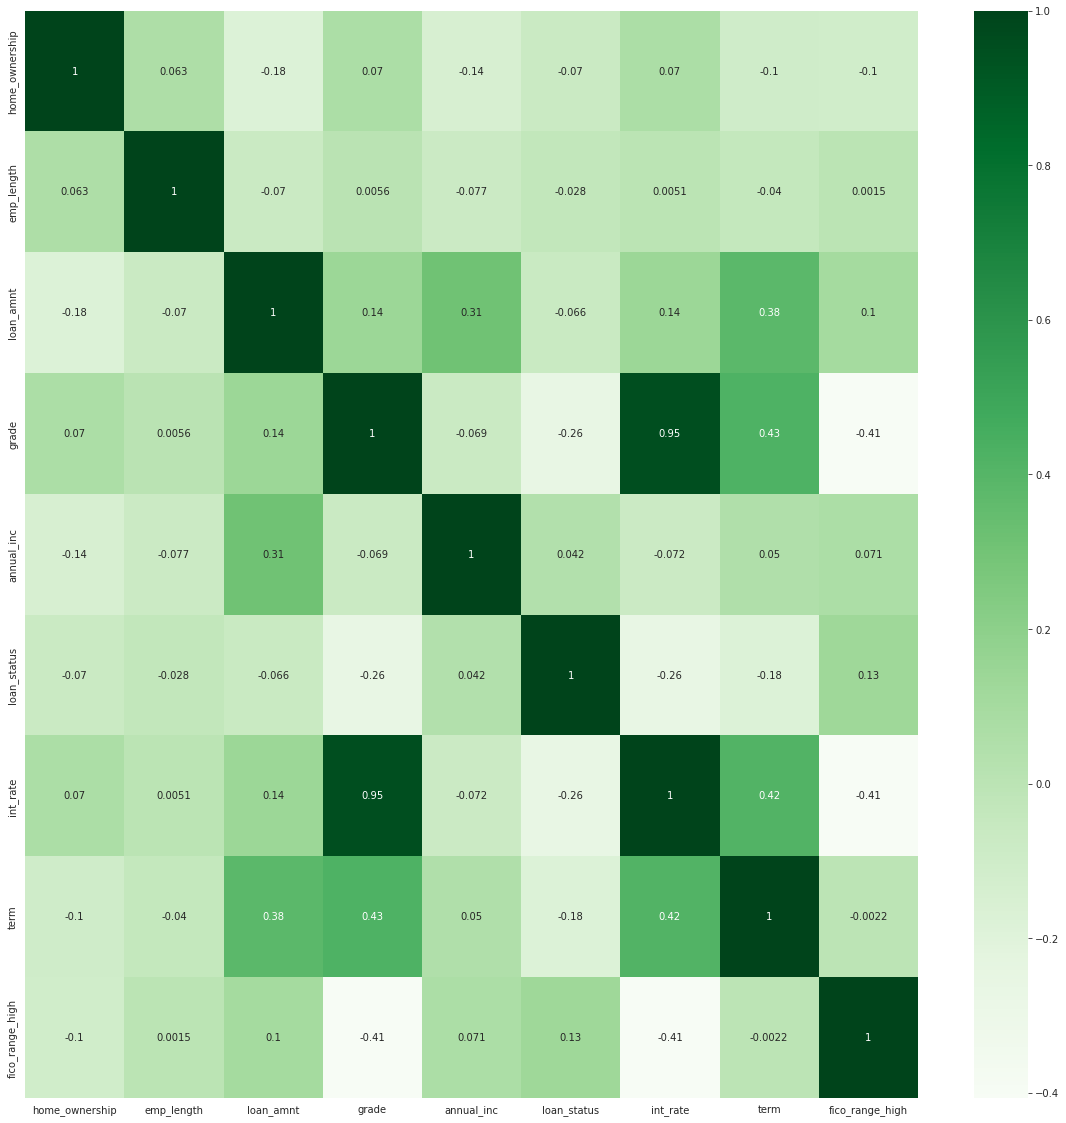

In [ ]:
plt.figure(figsize=(20,20))
sns.heatmap(df1_final.corr(), annot=True, cmap="Greens")

#### Checking the coefficients

In [ ]:
cor = df1_final.corr()
cor.loc[:,:] = np.tril(cor, k=-1) # below main lower triangle of an array
cor = cor.stack()
cor[(cor > 0.1) | (cor < -0.1)]

loan_amnt        home_ownership   -0.180640
grade            loan_amnt         0.142023
annual_inc       home_ownership   -0.143513
                 loan_amnt         0.311794
loan_status      grade            -0.261525
int_rate         loan_amnt         0.141673
                 grade             0.953275
                 loan_status      -0.258792
term             home_ownership   -0.101890
                 loan_amnt         0.380905
                 grade             0.425297
                 loan_status      -0.176096
                 int_rate          0.417230
fico_range_high  home_ownership   -0.104767
                 loan_amnt         0.100983
                 grade            -0.406472
                 loan_status       0.130682
                 int_rate         -0.405364
dtype: float64

## **7.4 Spliting the data into test and train**

In [ ]:
X= df1_final[['loan_amnt', 'annual_inc','int_rate','fico_range_high',
              'grade','home_ownership','emp_length','term']]

y= df1_final['loan_status']
X_train, X_test,y_train,y_test= train_test_split(X,y, test_size=0.2,random_state=42)

## **7.5 Standardizing numerical data**

In [ ]:
ind_num_cols= ['loan_amnt',  'annual_inc','int_rate','fico_range_high']
ss= StandardScaler()
X_train[ind_num_cols]= ss.fit_transform(X_train[ind_num_cols])
X_test[ind_num_cols]= ss.transform(X_test[ind_num_cols])
X_train

,loan_amnt,annual_inc,int_rate,fico_range_high,grade,home_ownership,emp_length,term
690509,-0.736162,0.196593,-1.415759,0.747491,0.0,5.0,0.0,0.0
907486,1.214316,0.053675,2.433070,-0.665236,4.0,5.0,6.0,0.0
87973,1.240131,0.768265,-0.115337,0.433552,2.0,5.0,1.0,0.0
317614,-0.506694,-0.660915,0.018900,-0.822206,2.0,5.0,4.0,0.0
1210762,1.558518,2.268903,-0.471904,-0.351297,1.0,1.0,5.0,1.0
...,...,...,...,...,...,...,...,...
110268,0.755380,-0.232161,-0.471904,-0.979176,1.0,5.0,2.0,0.0
259178,-0.277226,0.339511,-1.122115,-0.351297,0.0,4.0,5.0,0.0
131932,0.411178,-0.446538,-0.681650,0.433552,1.0,4.0,8.0,0.0
671155,-1.011523,-0.546580,0.530679,-0.508267,3.0,5.0,10.0,0.0


## **7.6 Training the data**

In [ ]:
model_start = time.time()

In [ ]:
key= ['LogisticRegression', 'DecisionTreeClassifier', 'DecisionTreeRegressor', 'GaussianNB', 'XGBClassifier', 'LGBMClassifier', 'KNeighborsClassifier']

value= [LogisticRegression(), DecisionTreeClassifier(), DecisionTreeRegressor(), GaussianNB(), XGBClassifier(), LGBMClassifier(), KNeighborsClassifier()]

models= dict(zip(key, value))

#key = ['RandomForestClassifier, 'SVC', 'CatBoostClassifier']
#values = [RandomForestClassifier(), SVC(), CatBoostClassifier(verbose=False)]
#models taking time: RandomForestClassifier, CatBoostClassifier, SVC

In [ ]:
models

{'LogisticRegression': LogisticRegression(),
 'DecisionTreeClassifier': DecisionTreeClassifier(),
 'DecisionTreeRegressor': DecisionTreeRegressor(),
 'GaussianNB': GaussianNB(),
 'XGBClassifier': XGBClassifier(),
 'LGBMClassifier': LGBMClassifier(),
 'KNeighborsClassifier': KNeighborsClassifier()}

In [ ]:
from numba import jit
from numba import vectorize
from numba import cuda

In [ ]:
scores=[]
for key,value in models.items():
    score= -1*cross_val_score(value, X,y, cv=5, scoring='neg_mean_absolute_error')
    scores.append(score)
    print(key, score.mean())

LogisticRegression 0.19968780429789415
DecisionTreeClassifier 0.314592919104147
DecisionTreeRegressor 0.3068489861249894
GaussianNB 0.2099902624673867


KeyboardInterrupt: ignored

In [ ]:
accuracy_scores=[]
for key,value in models.items():
    value.fit(X_train,y_train)
    y_pred= value.predict(X_test)
    accuracy= value.score(X_test,y_test)

    accuracy_scores.append(accuracy)
    print(key, accuracy)

In [ ]:
model_end = time.time()

In [ ]:
model_total_time = model_end - model_start

#### From the mean scores and accuracy scores, it can be seen that the Logistic Regression and LGBMClassifier are the best models.

## **7.7 Model Diagnostics**

## **7.7.1 Logistic Regression Model**

In [ ]:
logis= LogisticRegression(random_state=42)
logis.fit(X_train,y_train)
y_pred= logis.predict(X_test)

conf_m = confusion_matrix(y_test,y_pred)
print('The confusion Matrix: \n', conf_m)

clas_report = classification_report(y_test,y_pred)
print('\n\n\n Classification report: \n', clas_report)

p_pred = logis.predict_proba(X)
print('\n\n\n The predicted probability: \n',p_pred)

y_pred = logis.predict(X)
print('\n\n\n Model Prediction: \n',y_pred)

score_ = logis.score(X, y)
print('\n\n\n Model Score :\n',score)

#### **Tuning the hyperparameters**

In [ ]:
# define dataset
X, y = make_blobs(n_samples=1000, centers=2, n_features=100, cluster_std=20)
# define models and parameters
model = LogisticRegression(verbose = False)
solvers = ['newton-cg', 'lbfgs', 'liblinear']
penalty = ['l2']
c_values = [100, 10, 1.0, 0.1, 0.01]
# define grid search
grid = dict(solver=solvers,penalty=penalty,C=c_values)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
logis_clf = grid_search.fit(X, y)


In [ ]:
logis_clf.best_estimator_

In [ ]:
logis_clf.best_score_

#### After tuning the hyperparameters, the model has been fitted to get the probability of the test data.

In [ ]:
logis_clf.best_estimator_.fit(X_train,y_train)
y_pred= logis_clf.best_estimator_.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

#### **Plotting the confusion matrix for logistic regression model**

In [ ]:
disp = plot_confusion_matrix(
    logis_clf, X_test, y_test,
    cmap='YlOrBr', values_format='d',
    display_labels=['Default', 'Fully-Paid']
)

#### **Plotting the ROC curve for logistic regression model**

In [ ]:
probs = logis_clf.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## **7.7.2 LightGBM Classification Model**

In [ ]:
lgbm= LGBMClassifier(random_state=42)
lgbm.fit(X_train,y_train)
y_pred= lgbm.predict(X_test)

print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

#### **Tuning the hyperparameters**

In [ ]:
lgbm_params = {
 'colsample_bytree': [0.6,0.8,1.0],
 'learning_rate': [0.033,0.057,0.1],
 'max_depth': [3,4,5,6],
 'min_child_weight': [1,5,10,12],
 'n_estimators': [150,300,450,600],
 'num_leaves': [10,20,30],
 'subsample': [0.6,0.8,1.0]
 }

lgbm= LGBMClassifier(**lgbm_params)

lgbm

In [ ]:
lgbm_clf= RandomizedSearchCV(lgbm, param_distributions=lgbm_params, cv = 5, n_iter=5, verbose=1)

lgbm_clf.fit(X,y)

In [ ]:
lgbm_clf.best_estimator_

In [ ]:
lgbm_clf.best_score_

After tuning the hyperparameters, the model has been fitted to get the probability of the test data.

In [ ]:
lgbm_clf.best_estimator_.fit(X_train,y_train)
y_pred= lgbm_clf.best_estimator_.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

#### **Plotting the confusion matrix for LightGBM classification model**

In [ ]:
disp = plot_confusion_matrix(
    lgbm_clf, X_test, y_test,
    cmap='PuBu', values_format='d',
    display_labels=['Default', 'Fully-Paid']
)

#### **Plotting the ROC curve for Lightgbm classification model**

In [ ]:
probs = lgbm_clf.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## **7.8 Model comparison**

In [ ]:
ml_models = {
    'Logistic Regression': logis_clf,
    'LightGBM': lgbm_clf,
}

for model in ml_models:
    print(f"{model.upper():{30}} roc_auc_score: {roc_auc_score(y_test, ml_models[model].predict(X_test)):.3f}")

#### From the model diagnostics and roc_auc score, it can be stated that the logistic regression model is better for predicting the default client in the lending club dataset.

## **8. Business Model**

#### **Problem Statement:** Define your own business case for building a linear regression model. Define your Y  and choose appropriate independent variables . Remember there should be a sound business reason to do this .Define the use context for such a model clearly. Present the model and quantify the benefits of the model
#### **Business Model:** To predict the loan amount that can be borrowed.

#### **To predict how much loan can be borrowed, we chose the following variables:**

**Independent Variables:**
Term, interest rate, installment, employment length, home ownership, annual income, purpose, application type, and FICO range (low and high)
  
**Dependent Variable**

***loan_amnt:*** the listed amount of loan applied for by the borrower

#### **Use Context:**  A customer has approached Lending Club and requested a loan. Lending Club will collect the following information from her/him: Employee history, homeownership, annual income, the reason for the loan, loan type, high and low fico range, and so on.Investors can analyze the loan amount that it can provide, the interest rate, and the monthly installments based on the data shared by a customer and classify it as either default or repay.Based on the independent variables mentioned above, the model is designed to calculate an estimated loan that can be given to a customer.

In [ ]:
column = (mod_df.columns.values.tolist())
print(column)

#### After checking the definition of all the columns, some are being dropped as those are not related to the business model.

In [ ]:
df2 = mod_df[['loan_amnt', 'term', 'int_rate', 'installment', 'application_type', 'emp_length', 'home_ownership', 'annual_inc', 'purpose', 'fico_range_low', 'fico_range_high']]
df2.head()

In [ ]:
df2.info()

In [ ]:
df2.isnull().sum()

In [ ]:
df2.isnull().mean()

#### The columns have been divided into numerical and categorical for future analysis

In [ ]:
num_cols= ['loan_amnt' ,'int_rate', 'installment', 'annual_inc', 'fico_range_low', 'fico_range_high']
cat_cols= df2.drop(['loan_amnt' ,'int_rate', 'installment', 'annual_inc', 'fico_range_low', 'fico_range_high'], axis=1).columns

In [ ]:
cat_cols

In [ ]:
pd.value_counts(df2.term)

In [ ]:
pd.value_counts(df2.application_type)

In [ ]:
pd.value_counts(df2.emp_length)

In [ ]:
pd.value_counts(df2.home_ownership)

## **8.1 Encoding Categorical Variables**

In [ ]:
le= LabelEncoder()

for col in cat_cols:
    df2[col] = le.fit_transform(df2[col].astype(str))

df2.head()

## **8.2 Imputing missing values**

In [ ]:
lr= LinearRegression()

imputer = IterativeImputer(random_state=42, estimator=lr, max_iter=10, n_nearest_features=2, imputation_order = 'roman')
df2_final = imputer.fit_transform(df2)

df2_final = pd.DataFrame(df2_final, columns = df2.columns)

In [ ]:
df2_final.isnull().sum()

In [ ]:
df2_final.sample(5)

## **8.3 Correlation Matrix**

In [ ]:
plt.figure(figsize=(10,8))
sns.heatmap(df2_final.corr(), annot=True, cmap="YlGnBu")

#### Checking the coefficients

In [ ]:
cor = df2_final.corr()
cor.loc[:,:] = np.tril(cor, k=-1) # below main lower triangle of an array
cor = cor.stack()
cor[(cor > 0.1) | (cor < -0.1)]

## **8.4 Spliting the data into test and train**

In [ ]:
X= df2_final[['term', 'int_rate', 'installment', 'application_type', 'emp_length', 'home_ownership', 'annual_inc', 'purpose', 'fico_range_low', 'fico_range_high']]
y= df2_final['loan_amnt']
X_train, X_test,y_train,y_test= train_test_split(X,y, test_size=0.2,random_state=42)

In [ ]:
X_train

In [ ]:
y_train

## **8.5 Standardizing numerical data**

In [ ]:
mod_num_cols= ['int_rate', 'installment', 'annual_inc', 'fico_range_low', 'fico_range_high']
ss= StandardScaler()
X_train[mod_num_cols]= ss.fit_transform(X_train[mod_num_cols])
X_test[mod_num_cols]= ss.transform(X_test[mod_num_cols])
X_train

## **8.6 Linear Regression Model**

#### **Fitting The Model**

In [ ]:
lr.fit(X_train, y_train)

In [ ]:
print(lr.intercept_)
print(lr.coef_)

In [ ]:
coeff_df2 = pd.DataFrame(lr.coef_, X.columns, columns=['Coefficient'])
coeff_df2

In [ ]:
y_pred_train = lr.predict(X_train)

#### **Plotting the actual Y vs predicted Y for train dataset**

In [ ]:
plt.scatter(x = y_train, y = y_pred_train, color = "green")
plt.xlabel('Y train')
plt.ylabel('Predicted Y')
plt.show()

#### **Evaluating The Model**

#### Looking at the metrics for the train data.

In [ ]:
print('MAE:', metrics.mean_absolute_error(y_train, y_pred_train))
print('MSE:', metrics.mean_squared_error(y_train, y_pred_train))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_train, y_pred_train))),
print('R-squared: ',explained_variance_score(y_train, y_pred_train))

#### Making Predictions

In [ ]:
y_pred = lr.predict(X_test)

#### Comparing the actual output values for X_test with the predicted values.

In [ ]:
df3 = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
df3

#### **Evaluating The Algorithm**

#### Looking at the metrics for the test data.

In [ ]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('R-squared: ',explained_variance_score(y_test, y_pred))

#### **Plotting Actual vs Predicted Values**

#### Plotting The Best Fit Line

In [ ]:
fig, ax = plt.subplots()
ax.scatter(y_test, y_pred, color='grey')
ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4, color='blue')
ax.set_xlabel('Actual loan amount')
ax.set_ylabel('Predicted loan amount')
plt.show()

#### **Checking the residuals**

#### Plotting a histogram of the residuals to check if it is normally distributed.

In [ ]:
sns.distplot((y_test-y_pred), bins = 50)

#### It can be seen that the histogram of the residuals is normally distributed.

In [ ]:
prog_end = time.time()

In [ ]:
print("Total MODEL time: ", model_total_time/60 , "Minutes")

In [ ]:
total_prog_time = prog_end - prog_start

print("Total Program time: ", total_prog_time/60, "Minutes")